# Forecasting flight delays for domestic flights in US 

The ideia behind this project is to develop a model to predict flight delays (in minutes) at arrival for domestic flights in the US. The data used here was download from the Bureau of Transportation Statistics ([BTS](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)). 

The dataset comprises data between January 2017 and September 2018, with more than 10 millions training examples, so we have here a lot to work with and I'm expecting it to be too much of a "challenge" to old Dell. But not just yet. I will start with a smaller dataset, with data from June to September 2018, and then gradually increase it to see how the model behaves. 

----------------
----------------

* Year: 2017 to 2018.             
* Month: 1 to 12.                   
* Day_of_month: 1 to 31.            
* Day_of_week: 1 (Monday) to 7 (Sunday), 9 (Unknown).                       
* Op_carrier: Code assigned by IATA and commonly used to identify a carrier. May not be unique.         
* Op_carrier_fl_num: Flight number.             
* Origin: Origin airport.                               
* Origin_city_name: City name of the origin airport.                
* Origin_state_nm: State code of the origin airport.                  
* Dest: Destination airport.              
* Dest_city_name: City name of the destination airport.                
* Dest_state_nm: State name of the destination airport.                   
* CRS_dep_time: The schedule departure time (local time: hhmm).           
* Dep_delay_new: Difference in minutes between scheduled and actual departure time. Early departures set to 0.                 
* CRS_arr_time: The schedule arrival time (local time: hhmm).                                                    
* Arr_delay_new: Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0.                  
* Cancelled: Cancelled flight indicator, 0 (No), 1 (Yes).                                                       
* Diverted: Diverted flight indicator, 0 (No), 1 (Yes).               
* CRS_elapsed_time: The schedule elapsed time of flight, in minutes.                  
* Distance: Distance between aiportes, in miles.                      
---------------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
sep_2018 = pd.read_csv('./CSV_files/2018_09.csv')
aug_2018 = pd.read_csv('./CSV_files/2018_08.csv')
jul_2018 = pd.read_csv('./CSV_files/2018_07.csv')
jun_2018 = pd.read_csv('./CSV_files/2018_06.csv')

In [35]:
sep_2018.shape, aug_2018.shape, jul_2018.shape, jun_2018.shape

((585749, 20), (644673, 20), (645299, 20), (626193, 20))

In [36]:
summer_flights = pd.concat([jun_2018, jul_2018, aug_2018, sep_2018], ignore_index=True)

In [37]:
summer_flights.shape

(2501914, 20)

In [38]:
summer_flights.sample(10)

YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_CARRIER  OP_CARRIER_FL_NUM  \
2207344  2018      9             7            5         F9                807   
135845   2018      6             7            4         OO               5393   
2224883  2018      9            17            1         NK                903   
511886   2018      6            26            2         DL               2867   
631743   2018      7            25            3         9E               3445   
212829   2018      6            11            1         WN                435   
1224047  2018      7            31            2         OO               5638   
1117343  2018      7            29            7         DL               1849   
1879682  2018      8            31            5         WN               3243   
2418006  2018      9            19            3         AA               1680   

        ORIGIN           ORIGIN_CITY_NAME ORIGIN_STATE_NM DEST  \
2207344    BKG                Branson, MO        Missouri  DEN   
135845     ORD                Chicago, IL        Illinois  OKC   
2224883    ORD                Chicago, IL        Illinois  DFW   
511886     IAD             Washington, DC        Virginia  SEA   
631743     GSO  Greensboro/High Point, NC  North Carolina  LGA   
212829     ATL                Atlanta, GA         Georgia  MCO   
1224047    ORD                Chicago, IL        Illinois  MHT   
1117343    ATL                Atlanta, GA         Georgia  CAK   
1879682    BOS                 Boston, MA   Massachusetts  ATL   
2418006    PHL           Philadelphia, PA    Pennsylvania  ORD   

                DEST_CITY_NAME  DEST_STATE_NM  CRS_DEP_TIME  DEP_DELAY_NEW  \
2207344             Denver, CO       Colorado          1035           36.0   
135845       Oklahoma City, OK       Oklahoma          1922            0.0   
2224883  Dallas/Fort Worth, TX          Texas          2115            0.0   
511886             Seattle, WA     Washington           705          161.0   
631743            New York, NY       New York          1055            5.0   
212829             Orlando, FL        Florida          2010           94.0   
1224047         Manchester, NH  New Hampshire          1440           72.0   
1117343              Akron, OH           Ohio          2153            0.0   
1879682            Atlanta, GA        Georgia          1825            1.0   
2418006            Chicago, IL       Illinois          2125            0.0   

         CRS_ARR_TIME  ARR_DELAY_NEW  CANCELLED  DIVERTED  CRS_ELAPSED_TIME  \
2207344          1135           49.0          0         0               120   
135845           2143           10.0          0         0               141   
2224883          2343            0.0          0         0               148   
511886           1003          119.0          0         0               358   
631743           1243            0.0          0         0               108   
212829           2150           74.0          0         0               100   
1224047          1804           67.0          0         0               144   
1117343          2340            0.0          0         0               107   
1879682          2120            0.0          0         0               175   
2418006          2305            0.0          0         0               160   

         DISTANCE  
2207344       665  
135845        693  
2224883       802  
511886       2306  
631743        461  
212829        404  
1224047       843  
1117343       528  
1879682       946  
2418006       678

In [39]:
summer_flights.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501914 entries, 0 to 2501913
Data columns (total 20 columns):
YEAR                 2501914 non-null int64
MONTH                2501914 non-null int64
DAY_OF_MONTH         2501914 non-null int64
DAY_OF_WEEK          2501914 non-null int64
OP_CARRIER           2501914 non-null object
OP_CARRIER_FL_NUM    2501914 non-null int64
ORIGIN               2501914 non-null object
ORIGIN_CITY_NAME     2501914 non-null object
ORIGIN_STATE_NM      2501914 non-null object
DEST                 2501914 non-null object
DEST_CITY_NAME       2501914 non-null object
DEST_STATE_NM        2501914 non-null object
CRS_DEP_TIME         2501914 non-null int64
DEP_DELAY_NEW        2459542 non-null float64
CRS_ARR_TIME         2501914 non-null int64
ARR_DELAY_NEW        2451134 non-null float64
CANCELLED            2501914 non-null int64
DIVERTED             2501914 non-null int64
CRS_ELAPSED_TIME     2501914 non-null int64
DISTANCE             2501914 non-null in

------------
-------------
It seems that only DEP_DELAY_NEW and ARR_DELAY_NEW have some missing values, corresponding to approximately 1.7 and 2.0% of the training dataset, respectively. Some of these missing values may be due to flights that were cancelled or diverted.
As we are only intereted in flights that haven't been neither cancelled nor diverted, we can drop all rows where 'CANCELLED' or 'DIVERTED' reads 1. 

After that we can also drop both CANCELLED AND DIVERTED features as they don't really give us much information.

-------------
---------------

In [40]:
#training set
summer_flights = summer_flights[summer_flights.CANCELLED == 0]
summer_flights = summer_flights[summer_flights.DIVERTED == 0]

In [41]:
summer_flights.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2452233 entries, 0 to 2501913
Data columns (total 20 columns):
YEAR                 2452233 non-null int64
MONTH                2452233 non-null int64
DAY_OF_MONTH         2452233 non-null int64
DAY_OF_WEEK          2452233 non-null int64
OP_CARRIER           2452233 non-null object
OP_CARRIER_FL_NUM    2452233 non-null int64
ORIGIN               2452233 non-null object
ORIGIN_CITY_NAME     2452233 non-null object
ORIGIN_STATE_NM      2452233 non-null object
DEST                 2452233 non-null object
DEST_CITY_NAME       2452233 non-null object
DEST_STATE_NM        2452233 non-null object
CRS_DEP_TIME         2452233 non-null int64
DEP_DELAY_NEW        2450325 non-null float64
CRS_ARR_TIME         2452233 non-null int64
ARR_DELAY_NEW        2451134 non-null float64
CANCELLED            2452233 non-null int64
DIVERTED             2452233 non-null int64
CRS_ELAPSED_TIME     2452233 non-null int64
DISTANCE             2452233 non-null in

------------
------------
Just by dropping the flights that were either cancelled or diverted, the number of missing values of DEP_DELAY_NEW and ARR_DELAY_NEW decreased, respectively, to 0.078% and 0.045% of the total number of training instances. This corresponds to 1908 and 1099 NaNs, respectively. Given the size of the dataset, we can drop these values without losing too much information.

Just out of curiosity, during the months of June, July, August and September, 49681 flights were cancelled or diverted in the US.

------------
------------

In [42]:
summer_flights = summer_flights.drop(['CANCELLED', 'DIVERTED'], axis=1)
summer_flights = summer_flights.dropna()

In [43]:
summer_flights.isnull().sum()

YEAR                 0
MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
ORIGIN_CITY_NAME     0
ORIGIN_STATE_NM      0
DEST                 0
DEST_CITY_NAME       0
DEST_STATE_NM        0
CRS_DEP_TIME         0
DEP_DELAY_NEW        0
CRS_ARR_TIME         0
ARR_DELAY_NEW        0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64

In [44]:
summer_flights.describe()

YEAR         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  OP_CARRIER_FL_NUM  \
count  2449283.0  2.449283e+06  2.449283e+06  2.449283e+06       2.449283e+06   
mean      2018.0  7.477432e+00  1.588785e+01  3.994459e+00       2.614253e+03   
std          0.0  1.104612e+00  8.755905e+00  1.998427e+00       1.859048e+03   
min       2018.0  6.000000e+00  1.000000e+00  1.000000e+00       1.000000e+00   
25%       2018.0  6.000000e+00  8.000000e+00  2.000000e+00       1.044000e+03   
50%       2018.0  7.000000e+00  1.600000e+01  4.000000e+00       2.174000e+03   
75%       2018.0  8.000000e+00  2.300000e+01  6.000000e+00       4.094000e+03   
max       2018.0  9.000000e+00  3.100000e+01  7.000000e+00       7.439000e+03   

       CRS_DEP_TIME  DEP_DELAY_NEW  CRS_ARR_TIME  ARR_DELAY_NEW  \
count  2.449283e+06   2.449283e+06  2.449283e+06   2.449283e+06   
mean   1.328873e+03   1.507424e+01  1.480044e+03   1.547418e+01   
std    4.938811e+02   4.656568e+01  5.219093e+02   4.658760e+01   
min    1.000000e+00   0.000000e+00  1.000000e+00   0.000000e+00   
25%    9.100000e+02   0.000000e+00  1.055000e+03   0.000000e+00   
50%    1.320000e+03   0.000000e+00  1.510000e+03   0.000000e+00   
75%    1.735000e+03   8.000000e+00  1.918000e+03   1.000000e+01   
max    2.359000e+03   2.710000e+03  2.359000e+03   2.692000e+03   

       CRS_ELAPSED_TIME      DISTANCE  
count      2.449283e+06  2.449283e+06  
mean       1.408868e+02  8.101642e+02  
std        7.350631e+01  6.085029e+02  
min        1.000000e+00  3.100000e+01  
25%        8.800000e+01  3.660000e+02  
50%        1.210000e+02  6.390000e+02  
75%        1.700000e+02  1.042000e+03  
max        6.580000e+02  4.983000e+03

In [45]:
summer_flights.describe(include=['O'])

OP_CARRIER   ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_NM     DEST  \
count     2449283  2449283          2449283         2449283  2449283   
unique         17      351              345              52      351   
top            WN      ATL      Chicago, IL      California      ATL   
freq       450980   133684           144963          271959   133641   

       DEST_CITY_NAME DEST_STATE_NM  
count         2449283       2449283  
unique            345            52  
top       Chicago, IL    California  
freq           144632        272427

-----------
-----------
Just by a quick look at the statistics, it seems there are some "weird" values in the dataset, such CRS_ELAPSED_TIME of 1 min and ARR_DELAY_NEW of 2692 min (~ 45h).

We need to further check it:

-------------
-------------

In [46]:
#The shortest commercial flight in US lasts 16 min
summer_flights[summer_flights.CRS_ELAPSED_TIME <= 15]

YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_CARRIER  OP_CARRIER_FL_NUM  \
109223   2018      6             2            6         OO               5132   
787441   2018      7            10            2         YV               5903   
1143291  2018      7             4            3         YX               4493   
1412070  2018      8            19            7         OH               5123   

        ORIGIN    ORIGIN_CITY_NAME ORIGIN_STATE_NM DEST  \
109223     SLN          Salina, KS          Kansas  HYS   
787441     MTJ  Montrose/Delta, CO        Colorado  DFW   
1143291    MSP     Minneapolis, MN       Minnesota  LGA   
1412070    CLT       Charlotte, NC  North Carolina  PGV   

                DEST_CITY_NAME   DEST_STATE_NM  CRS_DEP_TIME  DEP_DELAY_NEW  \
109223                Hays, KS          Kansas          1710            0.0   
787441   Dallas/Fort Worth, TX           Texas          1227           13.0   
1143291           New York, NY        New York           709           43.0   
1412070         Greenville, NC  North Carolina          2225           24.0   

         CRS_ARR_TIME  ARR_DELAY_NEW  CRS_ELAPSED_TIME  DISTANCE  
109223           1715           16.0                 5        88  
787441           1328          194.0                 1       722  
1143291           810          216.0                 1      1020  
1412070          2226           89.0                 1       203

In [47]:
# I quicly googled these flights and it seems that what we have here are wrong values for CRS_ELAPSED_TIME. So I'm dropping them.
summer_flights = summer_flights[summer_flights.CRS_ELAPSED_TIME >= 15]

In [48]:
#Code for plotly histogram graph

'''arr_delay = go.Histogram(x=summer_flights['ARR_DELAY_NEW'], name='arrival', nbinsx=200)

layout = go.Layout(title='Distribution of Flight Delays', 
                   xaxis=dict(title='Delay time (min)'),
                   yaxis=dict(title='Count of flights', type='log'),
                   bargroupgap=0.2,
                   barmode='overlay')

data = [arr_delay]

hist_flight_delay = go.Figure(data=data, layout=layout)
iplot(hist_flight_delay)'''

"arr_delay = go.Histogram(x=summer_flights['ARR_DELAY_NEW'], name='arrival', nbinsx=200)\n\nlayout = go.Layout(title='Distribution of Flight Delays', \n                   xaxis=dict(title='Delay time (min)'),\n                   yaxis=dict(title='Count of flights', type='log'),\n                   bargroupgap=0.2,\n                   barmode='overlay')\n\ndata = [arr_delay]\n\nhist_flight_delay = go.Figure(data=data, layout=layout)\niplot(hist_flight_delay)"

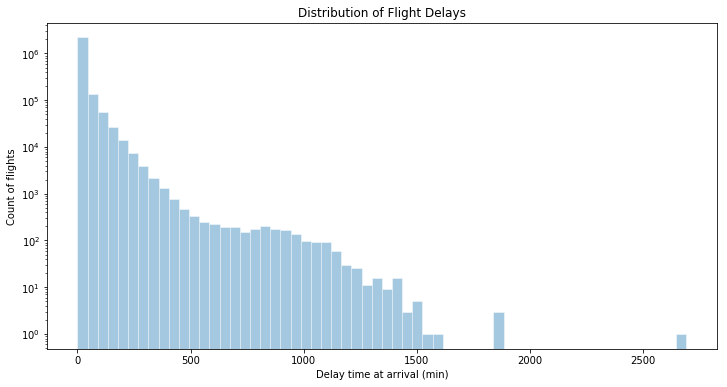

In [49]:
plt.figure(figsize=(12,6))
grid = sns.distplot(summer_flights['ARR_DELAY_NEW'], kde=False, bins=60, hist_kws={'edgecolor':'white', 'log':True})
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time at arrival (min)')
plt.show()

In [50]:
# Looking for flights that arrived more than 20h late.
print('Delays by over 20h:', summer_flights[summer_flights.ARR_DELAY_NEW >= 1200].shape[0])
print()

# Looking for flights that arrived more than 10h late.
print('Delays by over 10h:', summer_flights[summer_flights.ARR_DELAY_NEW >= 600].shape[0])

Delays by over 20h: 98

Delays by over 10h: 2007


-------------
-------------
Given the small amount of flights that were delayed by over 20h, we can see that they are not recurrent and may be due to "extraordinary circumstances". Actually, I would even say that delays over 10 hours are often beyond the airlines’ control and are hard to predict. So I'll consider them outliers and will drop them.

The maximum distance observed in the dataset is 4983 miles (almost 8020 km), which at a first glance seems to be an outlier, but after a further check I discovered it is quite right: it's the distance between Hoolulu (HNL) and New York (JFK) airports.


--------------
--------------

In [51]:
# dropping flights that were delayed by over 24h
summer_flights = summer_flights[summer_flights.ARR_DELAY_NEW <= 600]

-----------
-----------
Before further inspecting the data closely, we need to split it into training and test set.
I believe that delays may also been a function of airport capacity (flights per week) and it might be an important attribute to predict flight delays time. To ensure that the test set is representative of the various categories of airport capacity in the whole dataset, we may split the dataset using the Scikit-Learn's StratifiedShuffleSplit class.

The dataset is expressed as a fraction of the month, day and airline, so in order to make it more homogeneous and to guarantee that the test set will be similar to the training set, we also need to suffle the data (StratifiedShuffleSplit will do it automatically). It will also enhance the robustness of the cross validation as all cross-validation folds will be similar.

Let us create an airport capacity category attribute based on the total number of flights (departure and arrivals) of each airport:

------------
------------

In [52]:
airport_counts = summer_flights['ORIGIN'].value_counts()
airport_counts.describe()

count       351.000000
mean       6972.301994
std       16587.531987
min          23.000000
25%         324.000000
50%        1102.000000
75%        4546.500000
max      133595.000000
Name: ORIGIN, dtype: float64

In [53]:
airport_capacity = pd.cut(airport_counts, [0, 100, 250, 500, 1000, 2500, 5000, 10000, 50000, 150000]).value_counts()
airport_capacity

(1000, 2500]       71
(250, 500]         61
(100, 250]         46
(500, 1000]        42
(10000, 50000]     35
(5000, 10000]      31
(2500, 5000]       31
(0, 100]           19
(50000, 150000]    15
Name: ORIGIN, dtype: int64

------------
------------
As one can see, there are aiports with a capacity as lower as 23 flights or higher than 130000 flights every 4 months. The airports were divided in 9 new categories: 
{1 : '(0, 100]', 2 : '(100, 250]', 3 : '(250, 500]', 4 : '(500, 1000]', 5 : '(1000, 2500]',  6 : '(2500, 5000]', 
7 : '(5000, 10000]', 8 : '(10000, 50000]', 9 : '(50000, 150000]'}

------------
------------

In [54]:
#creating a dictionary for future reference
airport_cat_dic = {1 : '(0, 100]', 2 : '(100, 250]', 3 : '(250, 500]', 4 : '(500, 1000]', 5 : '(1000, 2500]', 
                   6 : '(2500, 5000]', 7 : '(5000, 10000]', 8 : '(10000, 50000]', 9 : '(50000, 150000]'}

airport_cat = pd.cut(airport_counts, [0, 100, 250, 500, 1000, 2500, 5000, 10000, 50000, 150000], labels = [1,2,3,4,5,6,7,8,9])
summer_flights['AIRP_CAT'] = summer_flights["ORIGIN"].map(airport_cat)

In [55]:
summer_flights.sample(5)

YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_CARRIER  OP_CARRIER_FL_NUM  \
1189142  2018      7            29            7         AS                116   
300786   2018      6            26            2         AA               1450   
1850057  2018      8            29            3         WN                751   
213004   2018      6            11            1         WN               2390   
1054110  2018      7            17            2         UA               2152   

        ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_NM DEST DEST_CITY_NAME  \
1189142    ANC    Anchorage, AK          Alaska  SEA    Seattle, WA   
300786     MIA        Miami, FL         Florida  LGA   New York, NY   
1850057    HOU      Houston, TX           Texas  TPA      Tampa, FL   
213004     BNA    Nashville, TN       Tennessee  DEN     Denver, CO   
1054110    IAH      Houston, TX           Texas  CLE  Cleveland, OH   

        DEST_STATE_NM  CRS_DEP_TIME  DEP_DELAY_NEW  CRS_ARR_TIME  \
1189142    Washington           232            0.0           700   
300786       New York          1845            0.0          2154   
1850057       Florida          1050            0.0          1400   
213004       Colorado          1105            0.0          1250   
1054110          Ohio          1433            0.0          1811   

         ARR_DELAY_NEW  CRS_ELAPSED_TIME  DISTANCE AIRP_CAT  
1189142            0.0               208      1448        7  
300786             0.0               189      1096        8  
1850057           63.0               130       781        8  
213004             0.0               165      1014        8  
1054110            0.0               158      1091        9

In [56]:
summer_flights.reset_index(drop=True, inplace=True) # to avoid the KeyError: Passing list-likes to .loc or [] with any missing 
                                                    # label will raise KeyError in the future, you can use .reindex() 
                                                    # as an alternative.

# Spliting data into training and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=87)
for train_index, test_index in split.split(summer_flights, summer_flights['AIRP_CAT']):
    flights_train = summer_flights.loc[train_index]
    flights_test = summer_flights.loc[test_index]
flights_train.shape, flights_test.shape

((1835458, 19), (611820, 19))

In [57]:
flights_train.head()

YEAR  MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_CARRIER  OP_CARRIER_FL_NUM  \
864647  2018      7            15            7         DL               1406   
291533  2018      6            18            1         AA               1431   
549721  2018      6            18            1         9E               4058   
629843  2018      7            24            2         9E               5172   
104448  2018      6             3            7         OO               3244   

       ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_NM DEST      DEST_CITY_NAME  \
864647    LAX  Los Angeles, CA      California  RDU  Raleigh/Durham, NC   
291533    ABQ  Albuquerque, NM      New Mexico  ORD         Chicago, IL   
549721    DTW      Detroit, MI        Michigan  BNA       Nashville, TN   
629843    IAH      Houston, TX           Texas  DTW         Detroit, MI   
104448    MDT   Harrisburg, PA    Pennsylvania  ORD         Chicago, IL   

         DEST_STATE_NM  CRS_DEP_TIME  DEP_DELAY_NEW  CRS_ARR_TIME  \
864647  North Carolina          1025          336.0          1824   
291533        Illinois           706            0.0          1103   
549721       Tennessee          2211          495.0          2247   
629843        Michigan          1515            0.0          1912   
104448        Illinois           750            0.0           902   

        ARR_DELAY_NEW  CRS_ELAPSED_TIME  DISTANCE AIRP_CAT  
864647          329.0               299      2239        9  
291533            0.0               177      1118        7  
549721          499.0                96       456        9  
629843            0.0               177      1075        9  
104448            0.0               132       594        5

-------------------
-------------------
## Exploratory data analysis

Ok, now that we had our dataset split, we can explore the data a little bit more in depth. To make manipulation easy and fast, let's sample a smaller exploratory set first.

In [58]:
# sampling an exploratory set of 200k training examples
train_explor = flights_train.sample(200000, random_state=87)

In [59]:
# Code for Plotly histogram graph

'''#checking if proportions were maintained
arr_delay = go.Histogram(x=flights_train['ARR_DELAY_NEW'], name='arrival', nbinsx=200)
arr_delay_exp = go.Histogram(x=train_explor['ARR_DELAY_NEW'], name='arrival', nbinsx=200)

layout = go.Layout(title='Distribution of Flight Delays - Original vs. Exploratory training set', 
                   xaxis=dict(title='Delay time (min)'),
                   yaxis=dict(title='Count of flights', type='log'),
                   bargroupgap=0.2,
                   barmode='overlay')

data = [arr_delay, arr_delay_exp]

hist_flight_delay = go.Figure(data=data, layout=layout)
iplot(hist_flight_delay)'''

"#checking if proportions were maintained\narr_delay = go.Histogram(x=flights_train['ARR_DELAY_NEW'], name='arrival', nbinsx=200)\narr_delay_exp = go.Histogram(x=train_explor['ARR_DELAY_NEW'], name='arrival', nbinsx=200)\n\nlayout = go.Layout(title='Distribution of Flight Delays - Original vs. Exploratory training set', \n                   xaxis=dict(title='Delay time (min)'),\n                   yaxis=dict(title='Count of flights', type='log'),\n                   bargroupgap=0.2,\n                   barmode='overlay')\n\ndata = [arr_delay, arr_delay_exp]\n\nhist_flight_delay = go.Figure(data=data, layout=layout)\niplot(hist_flight_delay)"

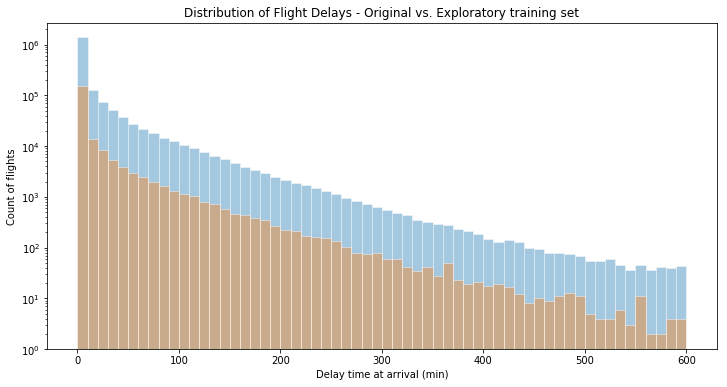

In [60]:
#checking if proportions were maintained
plt.figure(figsize=(12,6))
grid = sns.distplot(flights_train['ARR_DELAY_NEW'], kde=False, bins=60, hist_kws={'edgecolor':'white', 'log':True})
grid = sns.distplot(train_explor['ARR_DELAY_NEW'], kde=False, bins=60, hist_kws={'edgecolor':'white', 'log':True})
grid.set_title('Distribution of Flight Delays - Original vs. Exploratory training set')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time at arrival (min)')
plt.show()

In [61]:
original = flights_train.AIRP_CAT.value_counts() / len(flights_train) * 100
exploratory = train_explor.AIRP_CAT.value_counts() / len(train_explor) * 100
df_dtypes = pd.concat([original, exploratory], axis=1, keys=['training', 'exploratory'], join='outer', sort=True)
df_dtypes

training  exploratory
1   0.044621       0.0410
2   0.411777       0.3980
3   0.899067       0.8855
4   1.278210       1.2880
5   4.751621       4.7960
6   4.712393       4.7330
7   8.892658       8.8365
8  34.856096      34.9900
9  44.153557      44.0320

-------
-------
It seems that the exploratory set is similar to the training set.

--------
--------

In [62]:
dep_arr_delay = go.Scattergl(x=train_explor['DEP_DELAY_NEW'], y=train_explor['ARR_DELAY_NEW'], mode = 'markers', 
                             marker = dict(line = dict(width = 1)))

layout = go.Layout(title='Flight Delays at Departure vs. Arrival', 
                   xaxis=dict(title='Delay time at departure (min)'),
                   yaxis=dict(title='Delay time at arrival (min)',))
data = [dep_arr_delay]
hist_flight_delay = go.Figure(data=data, layout=layout)
iplot(hist_flight_delay)

-----------
-----------
In the graph above we can see some "strange" values that we need to check: it seems that some flights departed on time but arrived up to almost 180 min (3 h) late. There are also some flights that had a delayed departure of up to 50 min but arrived on time (maybe they took a shorter route? I have seen this happening on long-haul flights), but it is better to double check these values to see whether they make sense.

-------------
-------------